In [1]:
import numpy as np
import torch
import scipy
from bsgp.kernels import FullPrecisionRBF as BgpFullRBF
from bsgp.utils import apply_pca
import tensorflow as  tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
from generate_mocap_raw import create_mocap09

2023-08-14 15:47:31.025694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [79]:
latent_space = 15
T = 100
D = 62

In [80]:
def create_dataset(dataset='mocap_data_regression', d=5, T=100, normalize=False, fold=0):
    dataset_path = ('./data/' + dataset + '.npz')
    dataset = np.load(dataset_path)
    X, Y = dataset['X'], dataset['Y']

    # normalize data
    if normalize:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=fold)

    # normalize labels
    Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
    Y_train = (Y_train - Y_train_mean) / Y_train_std
    Y_test = (Y_test - Y_train_mean) / Y_train_std

    # apply PCA on X
    X_train, Pd = apply_pca(X_train, n_comp=d) 
    X_test = X_test @ Pd

    return X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std, Pd

In [81]:
X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std, Pd = create_dataset(dataset='mocap_data_regression',d=latent_space,T=T, normalize=True)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Pd: ', Pd.shape) # D x d

X_train:  (252, 15)
X_test:  (64, 15)
Pd:  (61, 15)


In [82]:
def get_lower_triangular_from_diag(d):
    lengthscales = np.full((d,), d**0.5, dtype=np.float64)
    Lambda = np.diag(1/(lengthscales**2))
    L = scipy.linalg.cholesky(Lambda, lower=True)
    return tfp.math.fill_triangular_inverse(L, upper=False) 
def kron_ones(P, t):
    P = tf.linalg.LinearOperatorFullMatrix([P])
    H = tf.linalg.LinearOperatorFullMatrix([tf.eye(t, dtype=tf.float64)])
    return tf.squeeze(tf.linalg.LinearOperatorKronecker([H, P]).to_dense())

class FullPrecisionRBF(gpflow.kernels.Kernel):  

    def __init__(self, **kwargs):
        randomized = kwargs["randomized"]
        self.d = kwargs["d"]
        self.input_dim = self.d
        self.T = kwargs["T"]
        self._v = kwargs["variance"]
        if not randomized:
            L = get_lower_triangular_from_diag(self.d)
        super().__init__()
        self.L = tf.Variable(L, name='L', dtype=tf.float64)
        self.logvariance = tf.Variable(np.log(self._v), dtype=tf.float64, name='log_variance', trainable=False)
        self.variance = tf.exp(self.logvariance)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        N1 = tf.squeeze(tf.shape(X)[:-1])
        N2 = tf.squeeze(tf.shape(X2)[:-1])
        Lambda = self.precision() # recover LLᵀ

        # compute z, z2
        z = self._z(X, Lambda) # N1x1 array
        z2 = self._z(X2, Lambda) # N2x1 array
        # compute X(X2Λ)ᵀ
        X2Lambda = tf.linalg.matmul(X2, Lambda)
        XX2LambdaT = tf.linalg.matmul(X, tf.transpose(X2Lambda)) # N1xN2 matrix
        # compute z1ᵀ 
        ones_N2 = tf.ones(shape=(N2,1), dtype=tf.float64) # N2x1 array
        zcol = tf.linalg.matmul(z, tf.transpose(ones_N2)) # N1xN2 matrix
        # compute 1z2ᵀ 
        ones_N1 = tf.ones(shape=(N1,1), dtype=tf.float64) # N1x1 array
        zrow = tf.linalg.matmul(ones_N1, tf.transpose(z2)) # N1xN2 matrix

        exp_arg = zcol - 2*XX2LambdaT + zrow
        Kxx = tf.math.exp(-0.5 * exp_arg)
        return self.variance * Kxx
    
    def K_diag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
    def Kdiag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
    def _z(self, X, Lambda):
        XLambda = tf.linalg.matmul(X, Lambda)
        XLambdaX = tf.math.multiply(XLambda, X)
        return tf.math.reduce_sum(XLambdaX, axis=1, keepdims=True)
    
    def precision(self):
        L = tfp.math.fill_triangular(self.L, upper=False) # recover L matrix from L array
        Lambda = tf.linalg.matmul(L, tf.transpose(L))
        #Lambda_expanded = kron_ones(Lambda, self.T)
        return Lambda
    
    def precision_off_diagonals(self):
        diag_L = tf.linalg.tensor_diag_part(self.precision())
        return self.precision() - tf.linalg.diag(diag_L)
    
    def precision_off_diagonals_prot(self):
        return tf.boolean_mask(self.precision(), ~tf.eye(self.d, self.d, dtype=tf.bool))


In [83]:
aid_kernel = FullPrecisionRBF(randomized=False, T=T, d=latent_space, variance=0.1)
model = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=aid_kernel,
    likelihood=gpflow.likelihoods.Gaussian(),
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.L,ResourceVariable,,,True,"(120,)",float64,"[-0.0000e+00, 0.0000e+00, 0.0000e+00..."
GPR.kernel.logvariance,ResourceVariable,,,False,(),float64,-2.30259
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.04493


In [84]:
f_mean, f_var = model.predict_f(X_test, full_cov=False)
y_mean, y_var = model.predict_y(X_test)

In [85]:
(np.mean(Y_test*Y_train_std - y_mean*Y_train_std)**2)**0.5

0.6864227643789573

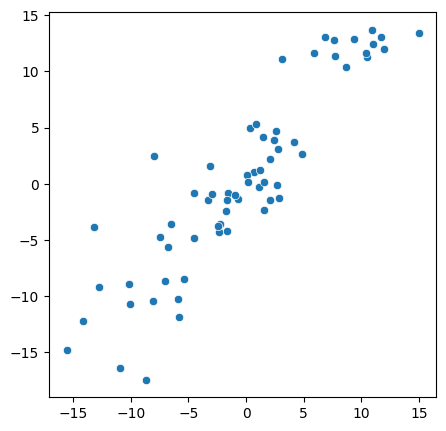

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=y_mean[:,0]*Y_train_std, y=Y_test[:,0]*Y_train_std)
plt.show()

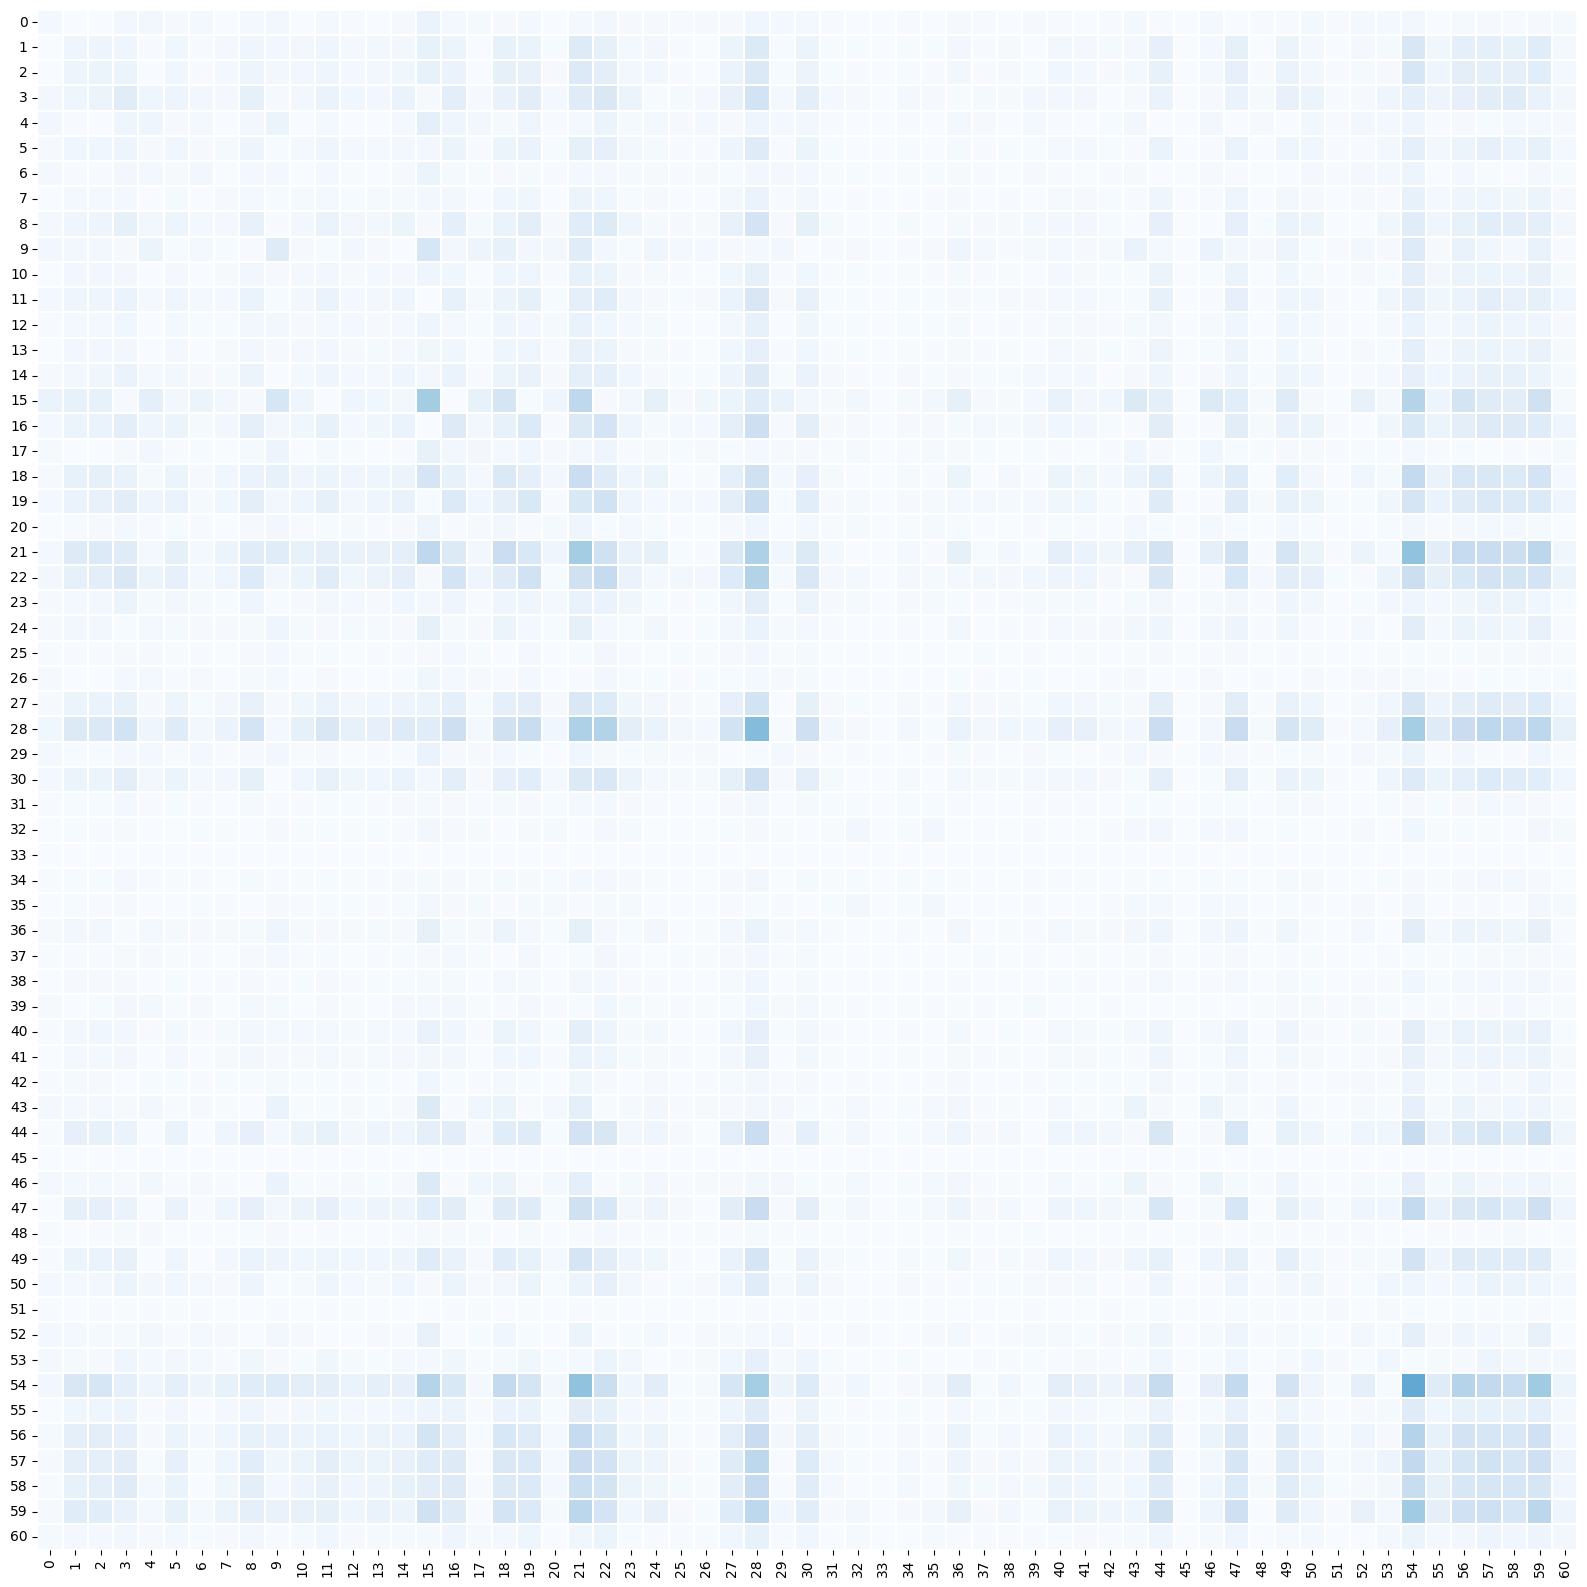

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
L = tfp.math.fill_triangular(model.kernel.L)
P = tf.linalg.matmul(L, tf.transpose(L)).numpy()
full_P = Pd @ P @ Pd.T
full_P = np.abs(full_P)
h = sns.heatmap(full_P, annot=False, square=True, cmap='Blues', fmt='.1f', vmax=np.max(P), vmin=0, center=np.max(P)/2, linewidth=.3, cbar=False, ax=ax)
#h.set_xticklabels(sensors_names)
#h.set_yticklabels(sensors_names)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
#ax.hlines(sensors_mask, *ax.get_xlim())
#ax.vlines(sensors_mask, *ax.get_xlim())
plt.show()